作業1：使用 TensorFlow 實作類神經網路模型預測股票價格（Dense layer）。
說明：使用收盤價或技術指標預測，預測N日後的股價。

In [213]:
import pandas as pd
r_data = pd.read_csv('./stock_data_1301_with_features.csv')
# 時間欄位轉換為 datetime
r_data['日期'] = pd.to_datetime(r_data['日期'])
# 計算布林通道
r_data['bb_up'] = r_data['收盤價'].rolling(window=20).mean() + 2 * r_data['收盤價'].rolling(window=20).std()
r_data['bb_down'] = r_data['收盤價'].rolling(window=20).mean() - 2 * r_data['收盤價'].rolling(window=20).std()
r_data = r_data.dropna()

print(r_data.dtypes)
print("------------------ 相關性分析 ")
correlation_matrix = r_data.corr()
print(correlation_matrix['收盤價'].sort_values(ascending=False))

日期             datetime64[ns]
開盤價                   float64
最高價                   float64
最低價                   float64
收盤價                   float64
SMA5                  float64
SMA10                 float64
SMA20                 float64
RSI                   float64
MACD                  float64
MACD_Signal           float64
bb_up                 float64
bb_down               float64
dtype: object
------------------ 相關性分析 
收盤價            1.000000
最低價            0.999532
最高價            0.999363
開盤價            0.998759
SMA5           0.996598
SMA10          0.991228
bb_down        0.984540
SMA20          0.982431
bb_up          0.942398
MACD_Signal    0.402982
MACD           0.385968
RSI            0.361318
日期            -0.917920
Name: 收盤價, dtype: float64


In [214]:
# 選擇相關性高的技術指標特徵＋收盤價，進行訓練
train_cols = ['收盤價', 'SMA5', 'SMA10', 'SMA20', 'bb_up', 'bb_down']


In [215]:
import tensorflow as tf

import numpy as np

# 預測未來 30 天的股價
n_days = 30

# 將 data 分為訓練資料、測試資料(最後30天)
raw_test_data = r_data.iloc[-30:]
raw_train_data = r_data.iloc[:-30]

input_dim = 6  # 學習特徵

# 訓練模型
# 訓練資料和標籤
train_data = raw_train_data[train_cols].values
train_labels = raw_train_data['收盤價'].values
test_data = raw_test_data[train_cols].values
test_labels = raw_test_data['收盤價'].values

features = np.array(train_data)
labels = np.array(train_labels)

# 定義模型
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu', input_shape=(input_dim,),
                        kernel_regularizer=tf.keras.regularizers.l2(0.01)
                        ),
    tf.keras.layers.Dense(units=64, activation='relu',
                        kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # L2 正則化
    tf.keras.layers.Dense(units=1)
])

# 編譯模型
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(features, labels, epochs=10, batch_size=32)


Epoch 1/10
20/20 [==============================] - 0s 797us/step - loss: 482.6445
Epoch 2/10
20/20 [==============================] - 0s 702us/step - loss: 26.0015
Epoch 3/10
20/20 [==============================] - 0s 628us/step - loss: 8.2962
Epoch 4/10
20/20 [==============================] - 0s 641us/step - loss: 5.3214
Epoch 5/10
20/20 [==============================] - 0s 590us/step - loss: 4.4478
Epoch 6/10
20/20 [==============================] - 0s 584us/step - loss: 4.1885
Epoch 7/10
20/20 [==============================] - 0s 572us/step - loss: 3.9119
Epoch 8/10
20/20 [==============================] - 0s 604us/step - loss: 3.5391
Epoch 9/10
20/20 [==============================] - 0s 566us/step - loss: 3.3570
Epoch 10/10
20/20 [==============================] - 0s 658us/step - loss: 3.1420


In [216]:
# 假設 test_features 和 test_labels 是你的測試資料和標籤
test_loss = model.evaluate(features, labels)
print(f"Test loss: {test_loss}")


20/20 [==============================] - 0s 639us/step - loss: 3.3086
Test loss: 3.3086111545562744


In [217]:
# 假設 last_known_features 是你目前已知的最後一組特徵
last_known_features = features[-1]  # 使用最後一筆資料的特徵


future_predictions = []
current_features = last_known_features

for _ in range(n_days):
    # 預測下一天的股價
    next_prediction = model.predict(current_features.reshape(1, -1))
    future_predictions.append(next_prediction[0, 0])
    
    # 更新特徵（這裡假設你可以用預測值更新特徵）
    # 這部分需要根據你的特徵工程來調整
    current_features = np.roll(current_features, -1)
    current_features[-1] = next_prediction[0, 0]

print(f'未來 {n_days} 天的股價預測：', future_predictions)

1/1 [==============================] - 0s 14ms/step
未來 30 天的股價預測： [47.474785, 48.770325, 48.52893, 51.715176, 49.63507, 48.471302, 49.370472, 49.175243, 50.140312, 50.343464, 49.705963, 49.850765, 49.903194, 50.11102, 50.443924, 50.368378, 50.366886, 50.44507, 50.522118, 50.700813, 50.795815, 50.837994, 50.9124, 50.984226, 51.089092, 51.19658, 51.275196, 51.354694, 51.434475, 51.520824]


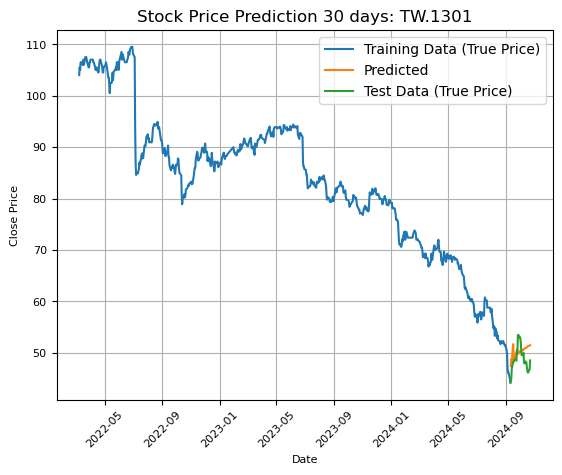

In [218]:
# 繪製圖表
import matplotlib.pyplot as plt

plt.plot(raw_train_data['日期'], raw_train_data['收盤價'], label='Training Data (True Price)')

# 生成加 10 天的交易日
future_dates = pd.date_range(start=raw_train_data['日期'].iloc[-1], periods=n_days + 1, freq='B')[1:]
test_dates = pd.date_range(start=raw_train_data['日期'].iloc[-1], periods=n_days + 1, freq='B')[1:]

plt.plot(future_dates, future_predictions, label='Predicted')
plt.plot(test_dates, test_labels, label='Test Data (True Price)')

plt.legend()
plt.title(f'Stock Price Prediction {n_days} days: TW.1301')
plt.xlabel('Date', fontsize=8)
plt.ylabel('Close Price', fontsize=8)
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.grid(True)

plt.show()
